In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import researchpy as rp
import pingouin as pg
from pingouin import ancova
import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower
from scipy.stats import ttest_ind
from statsmodels.formula.api import ols
from bioinfokit.analys import stat
from statsmodels.graphics.factorplots import interaction_plot
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly.graph_objs import *
datafile = "/Users/yunlin1207/Downloads/diabetes.csv"
df = pd.read_csv(datafile)

<h1>1. Data Cleaning<h1>

In [151]:
df.shape

(768, 9)

In [152]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [153]:
# use count to find the null value - here finds none
df.describe().T

count        mean         std     min       25%  \
Pregnancies               768.0    3.845052    3.369578   0.000   1.00000   
Glucose                   768.0  120.894531   31.972618   0.000  99.00000   
BloodPressure             768.0   69.105469   19.355807   0.000  62.00000   
SkinThickness             768.0   20.536458   15.952218   0.000   0.00000   
Insulin                   768.0   79.799479  115.244002   0.000   0.00000   
BMI                       768.0   31.992578    7.884160   0.000  27.30000   
DiabetesPedigreeFunction  768.0    0.471876    0.331329   0.078   0.24375   
Age                       768.0   33.240885   11.760232  21.000  24.00000   
Outcome                   768.0    0.348958    0.476951   0.000   0.00000   

                               50%        75%     max  
Pregnancies                 3.0000    6.00000   17.00  
Glucose                   117.0000  140.25000  199.00  
BloodPressure              72.0000   80.00000  122.00  
SkinThickness              23.0000   32.00000   99.00  
Insulin                    30.5000  127.25000  846.00  
BMI                        32.0000   36.60000   67.10  
DiabetesPedigreeFunction    0.3725    0.62625    2.42  
Age                        29.0000   41.00000   81.00  
Outcome                     0.0000    1.00000    1.00

In [154]:
df.drop (columns=['Glucose', 'BloodPressure', 'Insulin', 'DiabetesPedigreeFunction', 'Age'], inplace=True, axis= 1)

In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pregnancies    768 non-null    int64  
 1   SkinThickness  768 non-null    int64  
 2   BMI            768 non-null    float64
 3   Outcome        768 non-null    int64  
dtypes: float64(1), int64(3)
memory usage: 24.1 KB


In [156]:
#Consider data constraint
#if value could be zero or negative - SkinThickness/BMI can't be zero or below zero
#Replace these zero with NaN
df['SkinThickness'] = df['SkinThickness'].replace(0,np.nan)
df['BMI'] = df['BMI'].replace(0,np.nan)
df.isna().sum()
#Replace NaN with the median of that column
df.fillna(df.median(), inplace = True)

In [157]:
df.describe().T

count       mean       std   min   25%   50%   75%   max
Pregnancies    768.0   3.845052  3.369578   0.0   1.0   3.0   6.0  17.0
SkinThickness  768.0  29.108073  8.791221   7.0  25.0  29.0  32.0  99.0
BMI            768.0  32.455208  6.875177  18.2  27.5  32.3  36.6  67.1
Outcome        768.0   0.348958  0.476951   0.0   0.0   0.0   1.0   1.0

In [158]:
#Define the categorical variable
#Outcome
#BMI_Class
#Pregnancy_times

In [159]:
# Convert Outcome to category variable
df['Outcome']= df.Outcome.astype('category')
df['Outcome'].unique()
df.dtypes

Pregnancies         int64
SkinThickness     float64
BMI               float64
Outcome          category
dtype: object

In [160]:
# Add one column to show the BMI_Class category
# Underweight = <18.5
# Normal weight = 18.5–24.9 
# Overweight = 25–29.9 
# Obesity = BMI of 30 or greater
df['BMI_Class'] = pd.cut(df.BMI,bins=[0,18.5,24.9,29.9,float('Inf')],
                         labels=['Underweight','Normal weight','Overweight','Obesity'])
df.head()

Pregnancies  SkinThickness   BMI Outcome      BMI_Class
0            6           35.0  33.6       1        Obesity
1            1           29.0  26.6       0     Overweight
2            8           29.0  23.3       1  Normal weight
3            1           23.0  28.1       0     Overweight
4            0           35.0  43.1       1        Obesity

In [161]:
#Add one column to show the PregnancyTime category
#A:<=0 times
#B:>0 and <=2 times
#C:>2 times
df['Pregnancy_times'] = pd.cut(df.Pregnancies,bins=[-1,0,2,99999],labels=['A','B','C'])
df.head()

Pregnancies  SkinThickness   BMI Outcome      BMI_Class Pregnancy_times
0            6           35.0  33.6       1        Obesity               C
1            1           29.0  26.6       0     Overweight               B
2            8           29.0  23.3       1  Normal weight               C
3            1           23.0  28.1       0     Overweight               B
4            0           35.0  43.1       1        Obesity               A

In [195]:
df.dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Pregnancies      768 non-null    int64   
 1   SkinThickness    768 non-null    float64 
 2   BMI              768 non-null    float64 
 3   Outcome          768 non-null    category
 4   BMI_Class        768 non-null    category
 5   Pregnancy_times  768 non-null    category
dtypes: category(3), float64(2), int64(1)
memory usage: 20.8 KB


<h1>2. Exploratory Data Analysis<h1>

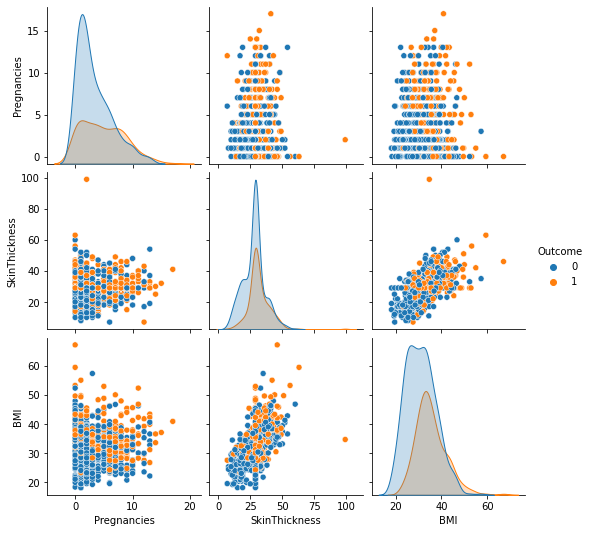

In [163]:
#check distribution and correlation of each continuous variable group by outcome
sns.pairplot(df, hue='Outcome')

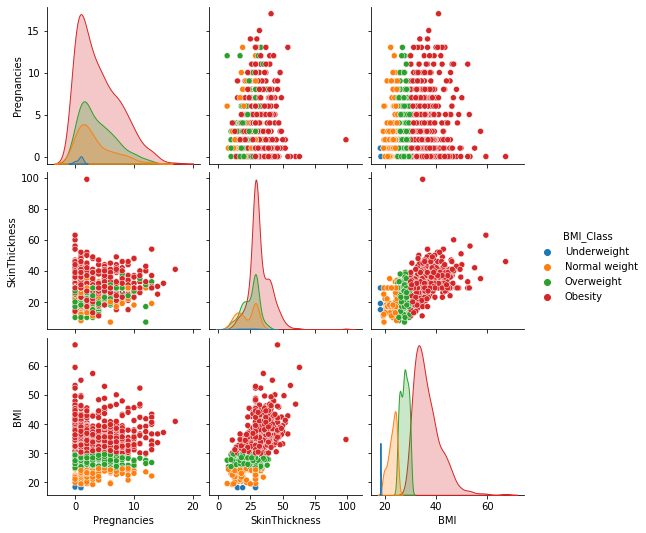

In [164]:
sns.pairplot(df, hue='BMI_Class')

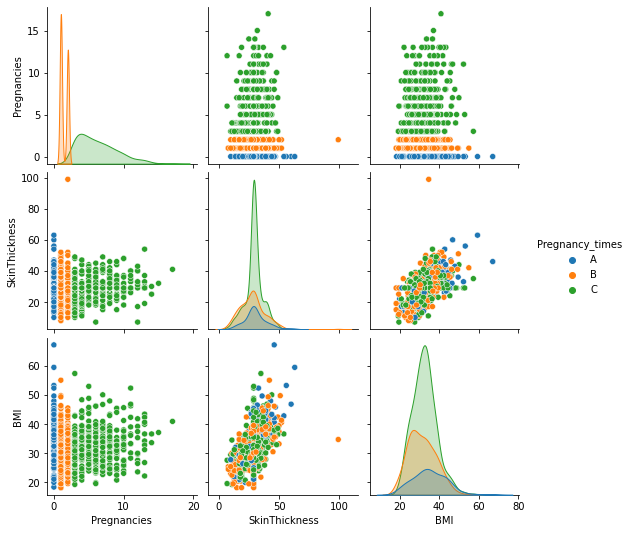

In [165]:
sns.pairplot(df, hue='Pregnancy_times')

<AxesSubplot:xlabel='Pregnancy_times', ylabel='SkinThickness'>

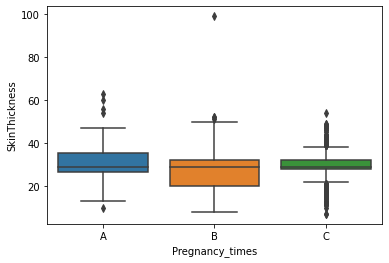

In [166]:
sns.boxplot(x='Pregnancy_times',y='SkinThickness',data=df)

<AxesSubplot:xlabel='BMI_Class', ylabel='SkinThickness'>

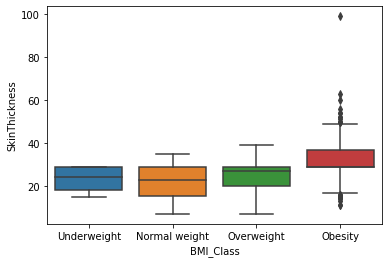

In [167]:
sns.boxplot(x='BMI_Class',y='SkinThickness',data=df)

<AxesSubplot:xlabel='Outcome', ylabel='SkinThickness'>

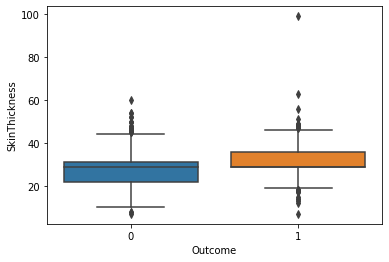

In [168]:
sns.boxplot(x='Outcome',y='SkinThickness',data=df)

<h1>3. Power Analysis<h1>

In [200]:
# parameters for the analysis 
effect_size = 0.2
#effect_size = 0.5
#effect_size = 0.8
alpha = 0.05 # significance level
power = 0.8

power_analysis = TTestIndPower()
sample_size = power_analysis.solve_power(effect_size = effect_size, 
                                         power = power, 
                                         alpha = alpha)

print('Required sample size: {0:.2f}'.format(sample_size))

Required sample size: 25.52


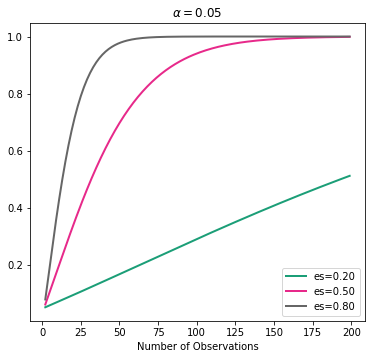

In [170]:
fig = plt.figure()
ax = fig.add_subplot(2,1,1)
fig = TTestIndPower().plot_power(dep_var='nobs',
                                 nobs= np.arange(2, 200),
                                 effect_size=np.array([0.2, 0.5, 0.8]),
                                 alpha=0.05,
                                 ax=ax, title=r'$\alpha = 0.05$' )
fig.subplots_adjust(top = 2.4)

<h1>4. T-tests<h1>

In [171]:
#Two Sample T-test - Outcome
a1 = df.loc[df['Outcome'] == 0]['SkinThickness']
b1 = df.loc[df['Outcome'] == 1]['SkinThickness']
stats.shapiro(b)
print('Without Diabetes:', a1.count())
print('With Diabetes:',b1.count())
tStat, pValue = stats.ttest_ind(a1, b1, equal_var = False) #run independent sample T-Test
print("P-Value:{0} T-Statistic:{1}".format(pValue,tStat)) #print the P-Value and the T-Statistic

Without Diabetes: 500
With Diabetes: 268
P-Value:2.471958498912807e-09 T-Statistic:-6.065718453761241


In [172]:
#calculate statistics power & Type II error
res = pg.ttest(a1, b1, correction=True)
display(res)

StatPower = power_analysis.solve_power(0.460988, power=None, nobs1=500, ratio=268/500, alpha=0.05)
print("statistics power:",StatPower)

T         dof alternative         p-val           CI95%  \
T-test -6.065718  540.009661   two-sided  2.471958e-09  [-5.24, -2.68]   

         cohen-d       BF10  power  
T-test  0.460988  3.917e+06    1.0

statistics power: 1.0


In [173]:
#Two Sample T-test - BMI
a2 = df.loc[df['BMI'] >= 25]['SkinThickness']
b2 = df.loc[df['BMI_Class'] == 'Normal weight']['SkinThickness']
print('OverWeight or above:', a2.count())
print('Normal weight:',b2.count())
tStat, pValue = stats.ttest_ind(a2, b2, equal_var = False) 
print("P-Value:{0} T-Statistic:{1}".format(pValue,tStat)) 

OverWeight or above: 662
Normal weight: 102
P-Value:3.998357570613665e-18 T-Statistic:9.939536591090105


In [174]:
#calculate statistics power & Type II error
res = pg.ttest(a2, b2, correction=True)
display(res)

StatPower = power_analysis.solve_power(0.943268, power=None, nobs1=662, ratio=102/662, alpha=0.05)
print("statistics power:",StatPower)

T         dof alternative         p-val         CI95%  \
T-test  9.939537  147.005243   two-sided  3.998358e-18  [6.33, 9.47]   

         cohen-d       BF10  power  
T-test  0.943268  5.931e+18    1.0

statistics power: 1.0


In [175]:
#Two Sample T-test - Pregnancy
a3 = df.loc[df['Pregnancies'] > 0]['SkinThickness']
b3 = df.loc[df['Pregnancy_times'] == 'A']['SkinThickness']
print('With Pregnancy experience', a3.count())
print('Without Pregnancy experience',b3.count())
tStat, pValue = stats.ttest_ind(a3, b3, equal_var = False)
print("P-Value:{0} T-Statistic:{1}".format(pValue,tStat))

With Pregnancy experience 657
Without Pregnancy experience 111
P-Value:0.06408001710143799 T-Statistic:-1.866029177889801


In [176]:
#calculate statistics power & Type II error
res = pg.ttest(a3, b3, correction=True)
display(res)

StatPower = power_analysis.solve_power(0.460988, power=None, nobs1=500, ratio=268/500, alpha=0.05)
print("statistics power:",StatPower)

T         dof alternative    p-val          CI95%   cohen-d  \
T-test -1.866029  143.391333   two-sided  0.06408  [-3.67, 0.11]  0.202834   

         BF10     power  
T-test  0.606  0.505665

statistics power: 1.0


<h1>5. ANOVA<h1>

<h3>One-way ANOVA<h3>

In [177]:
model1 = ols('SkinThickness ~ BMI_Class', df).fit()
aov_table1 = sm.stats.anova_lm(model1)
print(aov_table1)
#sns.boxplot(x='BMI_Class',y='SkinThickness',data=df)

              df        sum_sq      mean_sq          F        PR(>F)
BMI_Class    3.0  12546.622125  4182.207375  68.373854  3.580924e-39
Residual   764.0  46731.407823    61.166764        NaN           NaN


In [178]:
#post hoc corrections (Bonferroni)
pair_t = model1.t_test_pairwise('BMI_Class')
pair_t.result_frame

coef   std err          t         P>|t|  \
Normal weight-Underweight -0.705882  3.986398  -0.177073  8.594982e-01   
Overweight-Underweight     1.899441  3.953910   0.480396  6.310836e-01   
Obesity-Underweight        9.157350  3.926618   2.332121  1.995326e-02   
Overweight-Normal weight   2.605324  0.970251   2.685205  7.405758e-03   
Obesity-Normal weight      9.863232  0.852240  11.573300  1.178128e-28   
Obesity-Overweight         7.257909  0.684363  10.605346  1.311592e-24   

                           Conf. Int. Low  Conf. Int. Upp.     pvalue-hs  \
Normal weight-Underweight       -8.531475         7.119711  8.639007e-01   
Overweight-Underweight          -5.862376         9.661259  8.639007e-01   
Obesity-Underweight              1.449108        16.865592  5.867334e-02   
Overweight-Normal weight         0.700648         4.509999  2.929558e-02   
Obesity-Normal weight            8.190222        11.536243  7.068771e-28   
Obesity-Overweight               5.914453         8.601364  6.557962e-24   

                           reject-hs  
Normal weight-Underweight      False  
Overweight-Underweight         False  
Obesity-Underweight            False  
Overweight-Normal weight        True  
Obesity-Normal weight           True  
Obesity-Overweight              True

In [179]:
model2 = ols('SkinThickness ~ Pregnancy_times', df).fit()
aov_table2 = sm.stats.anova_lm(model2)
print(aov_table2)
#sns.boxplot(x='Pregnancy_times',y='SkinThickness',data=df)

                    df        sum_sq     mean_sq         F    PR(>F)
Pregnancy_times    2.0    595.500108  297.750054  3.881543  0.021026
Residual         765.0  58682.529840   76.709189       NaN       NaN


In [180]:
#post hoc corrections (Bonferroni)
pair_t = model2.t_test_pairwise('Pregnancy_times')
pair_t.result_frame

coef   std err         t     P>|t|  Conf. Int. Low  Conf. Int. Upp.  \
B-A -2.668446  1.006668 -2.650769  0.008197       -4.644606        -0.692285   
C-A -1.275022  0.934960 -1.363718  0.173057       -3.110414         0.560370   
C-B  1.393424  0.710904  1.960073  0.050350       -0.002130         2.788978   

     pvalue-hs  reject-hs  
B-A   0.024390       True  
C-A   0.173057      False  
C-B   0.098165      False

In [181]:
model3 = ols('SkinThickness ~ Outcome', df).fit()
aov_table3 = sm.stats.anova_lm(model3)
print(aov_table3)
#sns.boxplot(x='Outcome',y='SkinThickness',data=df)

             df        sum_sq      mean_sq          F        PR(>F)
Outcome     1.0   2736.896306  2736.896306  37.078538  1.793958e-09
Residual  766.0  56541.133642    73.813490        NaN           NaN


In [182]:
#post hoc corrections (Bonferroni)
pair_t = model3.t_test_pairwise('Outcome')
pair_t.result_frame

coef   std err         t         P>|t|  Conf. Int. Low  \
1-0  3.960567  0.650423  6.089215  1.793958e-09        2.683743   

     Conf. Int. Upp.     pvalue-hs  reject-hs  
1-0         5.237391  1.793958e-09       True

<h3>Two-way ANOVA<h3>

                               sum_sq     df             F        PR(>F)
C(BMI_Class)             1.254662e+04    3.0  6.863334e+01  2.744499e-39
C(Outcome)              -1.043064e-11    1.0 -1.711751e-13  1.000000e+00
C(BMI_Class):C(Outcome)  3.594841e+02    3.0  1.966473e+00  1.175698e-01
Residual                 4.637192e+04  761.0           NaN           NaN


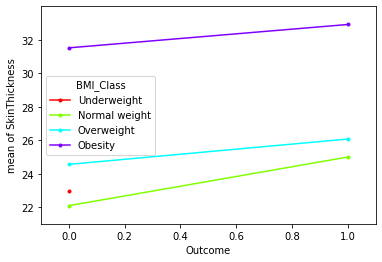

          group1         group2      Diff     Lower      Upper    q-value  \
0        Obesity     Overweight  7.257909  5.499178   9.016639  15.026656   
1        Obesity  Normal weight  9.863232  7.673078  12.053387  16.398146   
2        Obesity    Underweight  9.157350 -0.933585  19.248284   3.304370   
3     Overweight  Normal weight  2.605324  0.111895   5.098753   3.804652   
4     Overweight    Underweight  1.899441 -8.261630  12.060513   0.680670   
5  Normal weight    Underweight  0.705882 -9.538678  10.950443   0.250893   

    p-value  
0  0.001000  
1  0.001000  
2  0.090667  
3  0.036617  
4  0.900000  
5  0.900000  
   group1  group2      Diff     Lower     Upper   q-value  p-value
0       1       0  3.960567  2.800447  5.120687  9.477831    0.001


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/bioinfokit/analys.py:402: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/bioinfokit/analys.py:402: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [183]:
model4 = ols('SkinThickness ~ C(BMI_Class) + C(Outcome) + C(BMI_Class):C(Outcome)', df).fit()
anova_table4 = sm.stats.anova_lm(model4, typ=2)
print(anova_table4)
fig = interaction_plot(x=df['Outcome'], trace=df['BMI_Class'], response=df['SkinThickness'])
plt.show()
res = stat()
#for BMI
res.tukey_hsd(df, res_var='SkinThickness', xfac_var='BMI_Class', anova_model='SkinThickness ~ C(BMI_Class) + C(Outcome) + C(BMI_Class):C(Outcome)')
print(res.tukey_summary)
#for Outcome
res.tukey_hsd(df, res_var='SkinThickness', xfac_var='Outcome', anova_model='SkinThickness ~ C(BMI_Class) + C(Outcome) + C(BMI_Class):C(Outcome)')
print(res.tukey_summary)

                                     sum_sq     df          F        PR(>F)
C(Pregnancy_times)               346.442659    2.0   2.404151  9.102714e-02
C(Outcome)                      2487.838857    1.0  34.528891  6.275393e-09
C(Pregnancy_times):C(Outcome)   1291.878995    2.0   8.965040  1.417861e-04
Residual                       54902.811987  762.0        NaN           NaN


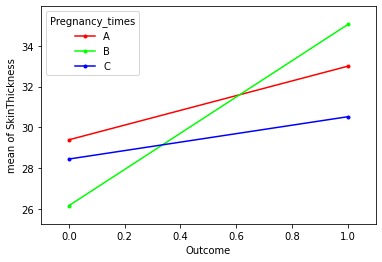

  group1 group2      Diff     Lower     Upper   q-value   p-value
0      C      B  1.393424 -0.224548  3.011395  2.860166  0.107586
1      C      A  1.275022 -0.852887  3.402931  1.989956  0.338394
2      B      A  2.668446  0.377333  4.959558  3.868039  0.017521
   group1  group2      Diff     Lower     Upper   q-value  p-value
0       1       0  3.960567  2.699069  5.222065  8.716143    0.001


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/bioinfokit/analys.py:402: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/bioinfokit/analys.py:402: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [184]:
model4 = ols('SkinThickness ~ C(Pregnancy_times) + C(Outcome) + C(Pregnancy_times):C(Outcome)', df).fit()
anova_table4 = sm.stats.anova_lm(model4, typ=2)
print(anova_table4)
fig = interaction_plot(x=df['Outcome'], trace=df['Pregnancy_times'], response=df['SkinThickness'])
plt.show()
res = stat()
#for Pregnancy_times
res.tukey_hsd(df, res_var='SkinThickness', xfac_var='Pregnancy_times', anova_model='SkinThickness ~ C(Pregnancy_times) + C(Outcome) + C(Pregnancy_times):C(Outcome)')
print(res.tukey_summary)
#for Outcome
res.tukey_hsd(df, res_var='SkinThickness', xfac_var='Outcome', anova_model='SkinThickness ~ C(Pregnancy_times) + C(Outcome) + C(Pregnancy_times):C(Outcome)')
print(res.tukey_summary)

In [185]:
model5 = ols('SkinThickness ~ C(Pregnancy_times) + C(BMI_Class) + C(Pregnancy_times):C(BMI_Class)', df).fit()
anova_table5 = sm.stats.anova_lm(model5, typ=2)
print(anova_table5)
#fig = interaction_plot(x=df['BMI_Class'], trace=df['Pregnancy_times'], response=df['SkinThickness'])
#plt.show()
res = stat()
#for Pregnancy_times
res.tukey_hsd(df, res_var='SkinThickness', xfac_var='Pregnancy_times', anova_model='SkinThickness ~ C(Pregnancy_times) + C(BMI_Class) + C(Pregnancy_times):C(BMI_Class)')
print(res.tukey_summary)
#for BMI_Class
res.tukey_hsd(df, res_var='SkinThickness', xfac_var='BMI_Class', anova_model='SkinThickness ~ C(Pregnancy_times) + C(BMI_Class) + C(Pregnancy_times):C(BMI_Class)')
print(res.tukey_summary)

                                       sum_sq     df          F        PR(>F)
C(Pregnancy_times)                  47.636351    2.0   0.399464  6.708206e-01
C(BMI_Class)                     12141.398839    3.0  67.876081  7.043055e-39
C(Pregnancy_times):C(BMI_Class)   1547.422969    6.0   4.325408  2.660012e-04
Residual                         45136.366158  757.0        NaN           NaN


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/bioinfokit/analys.py:402: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/bioinfokit/analys.py:402: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



  group1 group2      Diff     Lower     Upper   q-value   p-value
0      C      B  1.393424 -0.078455  2.865303  3.144095  0.068020
1      C      A  1.275022 -0.660750  3.210794  2.187499  0.270133
2      B      A  2.668446  0.584206  4.752685  4.252020  0.007679
          group1         group2      Diff     Lower      Upper    q-value  \
0        Obesity     Overweight  7.257909  5.518167   8.997650  15.190855   
1        Obesity  Normal weight  9.863232  7.696726  12.029739  16.577331   
2        Obesity    Underweight  9.157350 -0.824629  19.139328   3.340477   
3     Overweight  Normal weight  2.605324  0.138817   5.071830   3.846226   
4     Overweight    Underweight  1.899441 -8.151917  11.950799   0.688108   
5  Normal weight    Underweight  0.705882 -9.428063  10.839828   0.253635   

    p-value  
0  0.001000  
1  0.001000  
2  0.085548  
3  0.033746  
4  0.900000  
5  0.900000  


<h1>6. ANCOVA<h1>

In [189]:
ancova(data=df, dv= 'SkinThickness', covar = 'BMI', between= 'Pregnancy_times')

Source            SS   DF           F         p-unc       np2
0  Pregnancy_times     78.116006    2    0.715447  4.893009e-01  0.001869
1              BMI  16973.887815    1  310.919984  1.213980e-58  0.289249
2         Residual  41708.642025  764         NaN           NaN       NaN

In [190]:
ancova(data=df, dv= 'SkinThickness', covar = 'Pregnancies', between= 'BMI_Class')

Source            SS   DF          F         p-unc       np2
0    BMI_Class  12284.020268    3  67.047056  1.733440e-38  0.208622
1  Pregnancies    133.749069    1   2.190036  1.393188e-01  0.002862
2     Residual  46597.658754  763        NaN           NaN       NaN

In [193]:
pt = pg.pairwise_tukey(dv='SkinThickness',between='BMI_Class',effsize='cohen',data=df)
print(pt)

               A              B    mean(A)    mean(B)      diff        se  \
0    Underweight  Normal weight  23.000000  22.294118  0.705882  3.986398   
1    Underweight     Overweight  23.000000  24.899441 -1.899441  3.953910   
2    Underweight        Obesity  23.000000  32.157350 -9.157350  3.926618   
3  Normal weight     Overweight  22.294118  24.899441 -2.605324  0.970251   
4  Normal weight        Obesity  22.294118  32.157350 -9.863232  0.852240   
5     Overweight        Obesity  24.899441  32.157350 -7.257909  0.684363   

           T       p-tukey     cohen  
0   0.177073  9.980273e-01  0.090256  
1  -0.480396  9.634276e-01 -0.242867  
2  -2.332121  9.172100e-02 -1.170879  
3  -2.685205  3.711425e-02 -0.333122  
4 -11.573300  1.987299e-13 -1.261135  
5 -10.605346  1.987299e-13 -0.928012  


In [194]:
pt = pg.pairwise_tukey(dv='SkinThickness',between='Pregnancy_times',effsize='cohen',data=df)
print(pt)

   A  B    mean(A)    mean(B)      diff        se         T   p-tukey  \
0  A  B  30.630631  27.962185  2.668446  1.006668  2.650769  0.022303   
1  A  C  30.630631  29.355609  1.275022  0.934960  1.363718  0.360586   
2  B  C  27.962185  29.355609 -1.393424  0.710904 -1.960073  0.122938   

      cohen  
0  0.304674  
1  0.145577  
2 -0.159096  


<h1>7. Multiple Linear Regression<h1>

In [152]:
#MLR
df.head()

Pregnancies  SkinThickness   BMI Outcome      BMI_Class Pregnancy_times
0            6           35.0  33.6       1        Obesity               C
1            1           29.0  26.6       0     Overweight               B
2            8           29.0  23.3       1  Normal weight               C
3            1           23.0  28.1       0     Overweight               B
4            0           35.0  43.1       1        Obesity               A

In [153]:
x = df[['Pregnancies', 'BMI']]
y = df['SkinThickness']
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=0)

In [154]:
regr = LinearRegression()
regr.fit(X_train, y_train)
print('Intercept:', regr.intercept_)
coef = pd.DataFrame(regr.coef_,x.columns, columns=['Coefficient'])
#print(regr.coef_)
print(coef)

Intercept: 5.89857539738103
             Coefficient
Pregnancies     0.197466
BMI             0.691324


In [155]:
#prediction
y_pred = regr.predict(X_test)
predict1 = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
print('MAE:',metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))


#stats
x = sm.add_constant(x)
m = sm.OLS(y, x).fit()
predict2 = m.predict(x) 
print(model.summary())


MAE: 5.742151568630721
MSE: 52.8323593575475
RMSE: 7.2685871637855115
                            OLS Regression Results                            
Dep. Variable:          SkinThickness   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     163.9
Date:                Tue, 12 Apr 2022   Prob (F-statistic):           5.68e-60
Time:                        13:19:24   Log-Likelihood:                -2621.7
No. Observations:                 768   AIC:                             5249.
Df Residuals:                     765   BIC:                             5263.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------